In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import datetime
from wordcloud import WordCloud, STOPWORDS
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mymodel/model_10epoch_f.h5
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [21]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_df.tail(5)


,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [22]:
train_df["keyword"].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [23]:
train_df.shape
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [24]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [25]:
test_df.shape

(3263, 4)

In [26]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [27]:
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [28]:
train_df['keyword'] = train_df['keyword'].fillna('DUMMY_VALUE')
test_df['keyword'] = test_df['keyword'].fillna('DUMMY_VALUE')
train_df.isna().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [29]:
train_df['keyword'].value_counts()

DUMMY_VALUE              61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

Next we will merge Keyword and text feature and use this combined feature for detecting disaster tweets.

In [30]:
train_df['final_text'] = train_df['keyword'] + train_df['text']
test_df['final_text'] = test_df['keyword'] + test_df['text']

Next we will delete id, keyword and the location feature as it has large number of mising values and it also doesnt serve the purpose in detecting disaster tweets.

In [31]:

cols_del =['id','keyword','location']
train_df = train_df.drop(cols_del,axis=1)
test_df = test_df.drop(cols_del,axis=1)

In [32]:
train_df.head()

,text,target,final_text
0,Our Deeds are the Reason of this #earthquake M...,1,DUMMY_VALUEOur Deeds are the Reason of this #e...
1,Forest fire near La Ronge Sask. Canada,1,DUMMY_VALUEForest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...,1,DUMMY_VALUEAll residents asked to 'shelter in ...
3,"13,000 people receive #wildfires evacuation or...",1,"DUMMY_VALUE13,000 people receive #wildfires ev..."
4,Just got sent this photo from Ruby #Alaska as ...,1,DUMMY_VALUEJust got sent this photo from Ruby ...


In [33]:
train_df.tail()

,text,target,final_text
7608,Two giant cranes holding a bridge collapse int...,1,DUMMY_VALUETwo giant cranes holding a bridge c...
7609,@aria_ahrary @TheTawniest The out of control w...,1,DUMMY_VALUE@aria_ahrary @TheTawniest The out o...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,DUMMY_VALUEM1.94 [01:04 UTC]?5km S of Volcano ...
7611,Police investigating after an e-bike collided ...,1,DUMMY_VALUEPolice investigating after an e-bik...
7612,The Latest: More Homes Razed by Northern Calif...,1,DUMMY_VALUEThe Latest: More Homes Razed by Nor...


In [34]:
test_df.head()

,text,final_text
0,Just happened a terrible car crash,DUMMY_VALUEJust happened a terrible car crash
1,"Heard about #earthquake is different cities, s...",DUMMY_VALUEHeard about #earthquake is differen...
2,"there is a forest fire at spot pond, geese are...",DUMMY_VALUEthere is a forest fire at spot pond...
3,Apocalypse lighting. #Spokane #wildfires,DUMMY_VALUEApocalypse lighting. #Spokane #wild...
4,Typhoon Soudelor kills 28 in China and Taiwan,DUMMY_VALUETyphoon Soudelor kills 28 in China ...


### Class Distribution

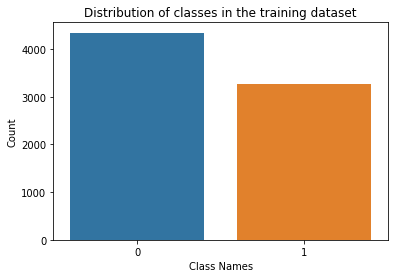

In [35]:
sns.countplot(x = 'target', data = train_df)
plt.xlabel('Class Names')
plt.ylabel('Count')
plt.title('Distribution of classes in the training dataset')
plt.show()

In [36]:
train_df['word_count'] = train_df.final_text.apply(len)
train_df.head()

,text,target,final_text,word_count
0,Our Deeds are the Reason of this #earthquake M...,1,DUMMY_VALUEOur Deeds are the Reason of this #e...,80
1,Forest fire near La Ronge Sask. Canada,1,DUMMY_VALUEForest fire near La Ronge Sask. Canada,49
2,All residents asked to 'shelter in place' are ...,1,DUMMY_VALUEAll residents asked to 'shelter in ...,144
3,"13,000 people receive #wildfires evacuation or...",1,"DUMMY_VALUE13,000 people receive #wildfires ev...",76
4,Just got sent this photo from Ruby #Alaska as ...,1,DUMMY_VALUEJust got sent this photo from Ruby ...,99


In [37]:
def cleaned_text(text):
    clean=re.sub("http\S+","",text)
    clean=re.sub("pic.twitter\S+","",clean)
    clean=re.sub("@\S+","",clean)
    clean = re.sub('#', '', clean)
    clean = re.sub('goooooooaaaaaal', 'goal', clean)
    clean = re.sub('SOOOO', 'SO', clean)
    clean = re.sub('LOOOOOOL', 'LOL', clean)
    clean = re.sub('Cooool', 'cool', clean)
    clean = re.sub('|', '', clean)
    clean = re.sub(r'\?{2,}', '? ', clean)
    clean = re.sub(r'\.{2,}', '. ', clean)
    clean = re.sub(r'\!{2,}', '! ', clean)
    clean = re.sub('&amp;', '&', clean)
    clean = re.sub('Comin', 'Coming', clean)
    clean = re.sub('&gt;', '> ', clean)
    clean = re.sub('&lt;', '< ', clean)
    clean = re.sub(r'.:', '', clean)
    clean = re.sub('baaaack', 'back', clean)
    clean = re.sub('RT', '', clean)
    clean = re.sub('\s{2,}', ' ', clean)
    clean = clean.lower()
    return clean
train_df['cleaned_text'] = train_df['final_text'].apply(cleaned_text)
test_df['cleaned_text'] = test_df['final_text'].apply(cleaned_text)

In [38]:
train_df.head()

,text,target,final_text,word_count,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,DUMMY_VALUEOur Deeds are the Reason of this #e...,80,dummy_valueour deeds are the reason of this ea...
1,Forest fire near La Ronge Sask. Canada,1,DUMMY_VALUEForest fire near La Ronge Sask. Canada,49,dummy_valueforest fire near la ronge sask. canada
2,All residents asked to 'shelter in place' are ...,1,DUMMY_VALUEAll residents asked to 'shelter in ...,144,dummy_valueall residents asked to 'shelter in ...
3,"13,000 people receive #wildfires evacuation or...",1,"DUMMY_VALUE13,000 people receive #wildfires ev...",76,"dummy_value13,000 people receive wildfires eva..."
4,Just got sent this photo from Ruby #Alaska as ...,1,DUMMY_VALUEJust got sent this photo from Ruby ...,99,dummy_valuejust got sent this photo from ruby ...


segregating disaster and normal tweets for plotting from training data

In [39]:
train_disaster = train_df[train_df['target']==1]
train_normal = train_df[train_df['target']==0]

### Distribution of Word Count of Disaster Tweets

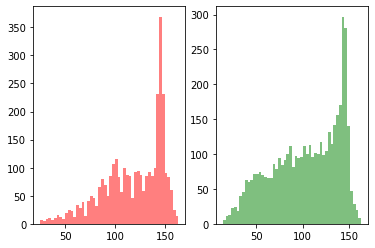

In [40]:

fig, ax = plt.subplots(1, 2)

disaster = train_disaster.word_count.to_list()
normal = train_normal.word_count.to_list()

ax[0].hist(disaster, bins=50, alpha = 0.5, color = 'r')
ax[1].hist(normal, bins=50, alpha = 0.5, color = 'g')

plt.show()

### Observation:

- Disaster tweets are comparatively shorter in length as compared to normal tweets in general

In [41]:
train_disaster.word_count.describe()

count    3271.000000
mean      117.563436
std        29.879465
min        25.000000
25%        97.000000
50%       124.000000
75%       144.000000
max       163.000000
Name: word_count, dtype: float64

In [56]:
print("a string with 163 words")
train_disaster[train_disaster['word_count'] == 163]['cleaned_text'].iloc[0]


a string with 163 words


'bioterrorism if 90blks 8whts colluded 2 take wht f auth hostage 2 make her look blk w bioterrorism use her lgl org idis id still hers '

In [57]:
#     train_df['cleaned_text'] = train_df['cleaned_text'].str.replace(char, ' ')
#     train_disaster['cleaned_text'] = train_disaster['cleaned_text'].str.replace(char, ' ')
#     train_normal['cleaned_text'] = train_normal['cleaned_text'].str.replace(char, ' ')
#     test_df['cleaned_text'] = test_df['cleaned_text'].str.replace(char, ' ')


In [58]:
spec_chars = ["!",'"',"#","%","&","'","(",")",         
              "*","+",",","-",".","/",":",";","<",        
              "=",">","?","@","[","\\","]","^","_",        
              "`","{","|","}","~","–"]
for char in spec_chars:
    train_df.loc[:, 'cleaned_text'] = train_df['cleaned_text'].str.replace(char, ' ')
    train_disaster.loc[:, 'cleaned_text'] = train_disaster['cleaned_text'].str.replace(char, ' ')
    train_normal.loc[:, 'cleaned_text'] = train_normal['cleaned_text'].str.replace(char, ' ')
    test_df.loc[:, 'cleaned_text'] = test_df['cleaned_text'].str.replace(char, ' ')



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykern

In [59]:
# spec_chars = ["!",'"',"#","%","&","'","(",")",
#               "*","+",",","-",".","/",":",";","<",
#               "=",">","?","@","[","\\","]","^","_",
#               "`","{","|","}","~","–"]
# for char in spec_chars:
#     train_df['cleaned_text'] = train_df['cleaned_text'].str.replace(char, ' ')
#     train_disaster['cleaned_text'] = train_disaster['cleaned_text'].str.replace(char, ' ')
#     train_normal['cleaned_text'] = train_normal['cleaned_text'].str.replace(char, ' ')
#     test_df['cleaned_text'] = test_df['cleaned_text'].str.replace(char, ' ')
    

### Word cloud Disaster Tweets

In [60]:
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(' '.join(train_disaster['cleaned_text']))

<Figure size 864x576 with 0 Axes>

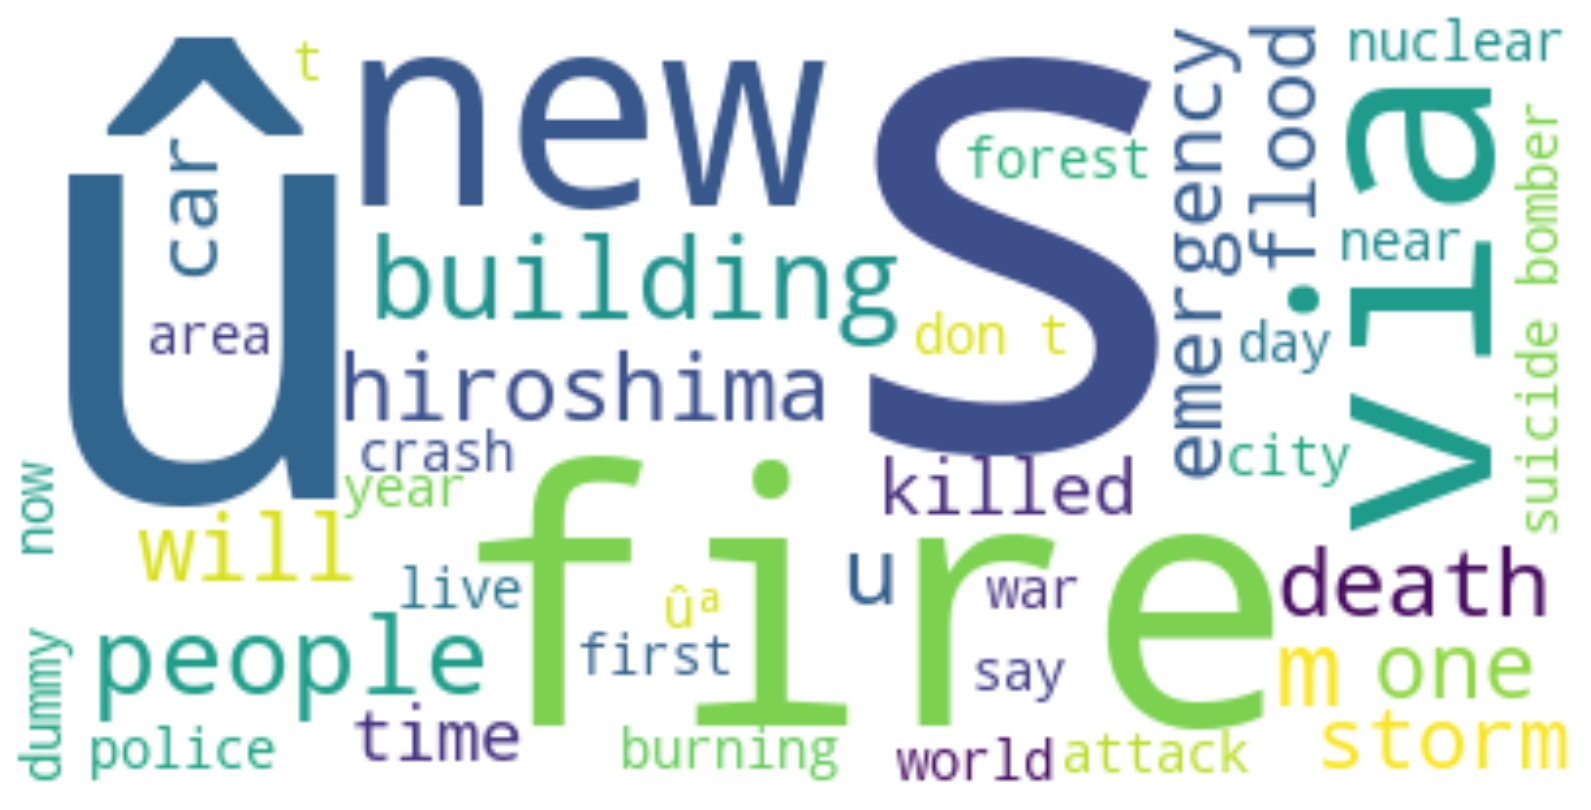

In [61]:
print(wordcloud)
fig = plt.figure(1)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word Cloud Normal Tweets

<Figure size 432x288 with 0 Axes>

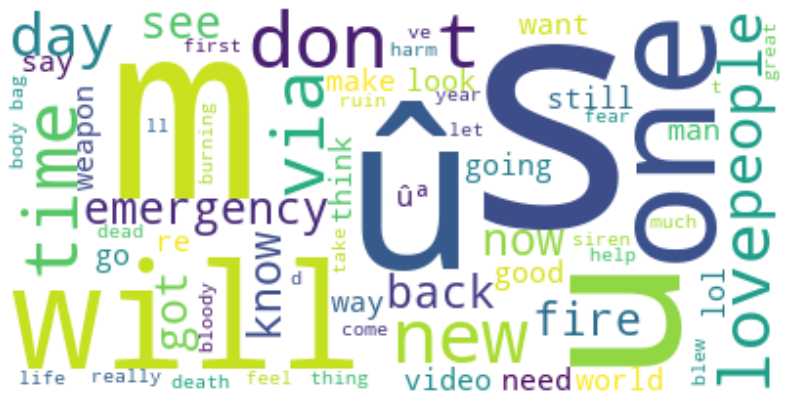

In [48]:
wordcloud = WordCloud(background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(' '.join(train_normal['cleaned_text']))
print(wordcloud)
fig = plt.figure(1)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Observations

- From both the Word clouds we can easily see the difference between disaster and normal tweets

In [62]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_df, test_size=0.2)

### Bert Modelling

#### About BERT

BERT is an acronym of **Bidirectional Encoder Representations from Transformers**. The term bidirectional means that the context of a word is given by both the words that follow it and by the words preceding it. This technique makes this algorithm hard to train but very effective. Exploring the surrounding text around words is computationally expensive but allows a deeper understanding of words and sentences.

![bert](https://pytorch.org/tutorials/_images/bert.png)

Unidirectional context-oriented algorithm already exist. A neural network can be trained to predict which word will follow a sequence of given words, once trained on a huge dataset of sentences. However, predicting that word from both the previous and following words is not an easy task. 

The only way to do so effectively is to mask some words in a sentence and predict them too, e.g., the sentence **the quick brown fox jumps over the lazy dog** might be masked as **the X brown fox jumps over the Y dog** with label (**X = quick, Y = lazy**) to become a labelled record in a training set of sentences. One can easily derive a training set from a bundle of unsupervised texts by simply masking 15% of words (as BERT does), and training the neural network to deduce the missing words from the remaining ones.

Notice that BERT is truly a deep learning algorithm, while context-free algorithms such as word2vec, based on shallow recurrent networks, may not be. 

However, as such, BERT’s training is very expensive, due to its transformer aspect. Training on a huge body of text – for example, all English-language Wikipedia pages – is an Herculean effort that requires decidedly nontrivial computational power.

Whatever the task, it is not necessary to pre-train the BERT model, but only to fine-tune a pre-trained model on the specific dataset that relates to the problem we want to use BERT to study. We will try to use such a pre-trained model to perform our simple classification task: more exciting use cases may be found on the GitHub page of the project mentioned above, as well as elsewhere on the Web.

First, we choose the pre-trained model: in the BERT GitHub repository there are several choices available, we will use `uncased_L-12_H-768_A-12`.

The pre-trained model can be downloaded from the repository and extracted into a local folder. This folder will contain the following files:

- **bert_config.json**
- **bert_model.ckpt.data-00000-of-00001**
- **bert_model.ckpt.index**
- **vocab.txt**

The first file contains all the configuration necessary to build a network layer to use this BERT model, while the latter files are needed to properly tokenize our texts. The largest file contains the model, which may be loaded from the BERT library using the methods demonstrated below.

To remain focused on the model, the assumption will be that our code is run inside a directory. This is necessary before running the following programs:

Before setting up the model, our dataset is tokenized according to the format expected by the BERT layers; this can be done via the **FullTokenizer** class from the BERT package. 

Next, the tokenizer is fed with each sentence in our datsaset. The tokenizer result, which is a list of strings, between **[CLS]** and **[SEP]** is enclosed, as required by the BERT algorithm implementation.

The output of our model will be simply a number between 0 and 1.

In [63]:
# reqire to download tensorflow 2 for bert without that it shows error
!pip install bert-for-tf2

#pip install bert-for-tf2 installs the bert-for-tf2 package, 
# which is a TensorFlow 2.0 compatible version of the BERT model. 
# The package provides pre-trained BERT models and associated code
# to fine-tune them for specific NLP tasks.
# It is necessary to install this package to use the BERT model in TensorFlow 2.0.





>**** %matplotlib inline, is a magic command that tells Jupyter to display plots directly in the notebook, rather than in a separate window or file. It enables interactive figures within the notebook.

> ****The second line, %config InlineBackend.figure_format='retina', sets the resolution of the inline plots to a higher value. This can make the plots appear sharper and clearer on high-resolution displays.

In [64]:
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'



sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

>  np.random.seed(RANDOM_SEED) sets the NumPy random seed to a fixed value RANDOM_SEED, which ensures that the same sequence of random numbers will be generated each time the code is run. This is useful for obtaining reproducible results in experiments that involve randomness.

> tf.random.set_seed(RANDOM_SEED) sets the TensorFlow random seed to RANDOM_SEED. This ensures that TensorFlow operations that involve randomness, such as initialization of weights in a neural network, are also reproducible.Reproducible" means that the results of the code can be replicated exactly in the same environment, with the same initial settings and inputs. In this context, setting the random seed to a fixed value ensures that the same sequence of random numbers is generated every time the code is run. This helps to produce consistent and predictable results and makes it easier to compare the performance of different models or methods.

"wget" to download a zip file from the specified URL, which contains the pre-trained weights and configuration files for a version of the BERT (Bidirectional Encoder Representations from Transformers) model.

The specific model being downloaded is the "uncased_L-12_H-768_A-12" variant of BERT, which has 12 layers, 768 hidden units per layer, and a total of 110 million parameters. The "uncased" part of the model name indicates that the text is lowercased before being processed by the model

In [65]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2023-08-06 03:47:56--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 142.250.99.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M   236MB/s    in 1.6s    

2023-08-06 03:47:57 (236 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [66]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [67]:
import os 
os.makedirs("model", exist_ok=True)

In [68]:
os.makedirs("model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

mv: cannot move 'uncased_L-12_H-768_A-12/' to 'model/uncased_L-12_H-768_A-12': Directory not empty


The BERT **checkpoint
** file (bert_model.ckpt) contains the pre-trained weights of the BERT model, and is necessary for using the model to make predictions. The BERT configuration file (bert_config.json) contains the hyperparameters and architecture of the BERT model, and is necessary for correctly initializing the model before making predictions. Finally, the BERT model directory (model/) is the directory where the pre-trained BERT model files are stored.**checkpoint
**

**The number of parameters in the pre-trained BERT model is 110 million, and the number of neurons in the model is 110 x 10^6.**

In [69]:
import tensorflow as tf
from transformers import TFBertModel, BertConfig

# Load the pre-trained BERT model configuration
config = BertConfig.from_pretrained('bert-base-uncased')

# Instantiate the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)

# Access the pre-trained weights of the BERT model
bert_weights = bert_model.get_weights()

# Print the first layer's weight matrix
print(bert_weights[0])


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


[[-0.01018257 -0.06154883 -0.02649689 ... -0.01985357 -0.03720997
  -0.00975152]
 [-0.01170495 -0.06002603 -0.03233192 ... -0.01681456 -0.04009988
  -0.0106634 ]
 [-0.01975381 -0.06273633 -0.03262176 ... -0.01650258 -0.04198876
  -0.00323178]
 ...
 [-0.02176224 -0.0556396  -0.01346345 ... -0.00432698 -0.0151355
  -0.02489496]
 [-0.04617237 -0.05647721 -0.00192082 ...  0.01568751 -0.01387033
  -0.00945213]
 [ 0.00145601 -0.08208051 -0.01597912 ... -0.00811687 -0.04746607
   0.07527421]]


In [70]:
print(len(bert_weights)),print(len(bert_weights[0]))


199
30522


(None, None)

**To understand the parameters of the model,  refer to the configuration file (bert_config.json) which contains the hyperparameters and architecture of the model. This file provides information about the number of layers, the number of hidden units in each layer, the size of the vocabulary, the maximum sequence length, and other important parameters that define the model.By examining the configuration file and the pretrained weights, we can get a sense of how the model was trained and what knowledge it has learned. we can also use this information to fine-tune the model on your specific task or to build our own BERT-based models.**

In [72]:
import json

# Open the file and load the JSON data
with open(bert_config_file, 'r') as f:
    config = json.load(f)
print("These hyperparameters and architecture settings are used to initialize the BERT model before making predictions.")
# Print the contents of the file
print(config)


These hyperparameters and architecture settings are used to initialize the BERT model before making predictions.
{'attention_probs_dropout_prob': 0.1, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'max_position_embeddings': 512, 'num_attention_heads': 12, 'num_hidden_layers': 12, 'type_vocab_size': 2, 'vocab_size': 30522}



GELU stands for Gaussian Error Linear Unit. It is a non-linear activation function used in neural networks, particularly in deep learning models. The GELU function is similar to the ReLU (Rectified Linear Unit) activation function but has a smoother curve and better performance for certain types of models. The GELU function is defined as a combination of the standard normal cumulative distribution function and the identity function.

**Bert working as word embedder**

In [73]:
def bert_encode(texts, tokenizer, max_len=512):
    # bert can support max length of 512 only 
    # here we need 3 data inputs for bert training and fine tuning 
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2] # here we are trimming 2 words if they getting bigger than 512.For each input text,
#the function first tokenizes the text using the tokenizer. It then trims the tokenized text to a maximum length of max_len-2 
##(since BERT requires special tokens [CLS] and [SEP] at the beginning and end of each input sequence).
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens) ##Token embedding
        all_masks.append(pad_masks) ##Position Embedding
        all_segments.append(segment_ids)##
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

**pad_masks = [1] * len(input_sequence) + [0] * pad_len: This line creates a binary mask for the input sequence that indicates which tokens are actual words and which ones are padding. It creates a list of 1s with a length equal to the length of the input_sequence (including the [CLS] and [SEP] tokens), followed by a list of 0s with a length equal to the padding length pad_len. The resulting mask is stored in the pad_masks variable.
segment_ids = [0] * max_len: This line creates a list of segment IDs that will be used by BERT to distinguish between the different sequences in a batch. Since we are only dealing with a single sequence here, all the segment IDs are set to 0.**

I will save my model here

In [74]:
os.makedirs("ALkAmodel", exist_ok=True)
print(os.getcwd())
bertNewmodel="ALkAmodel/"
newmodelDir = os.path.join("/kaggle/working/", bertNewmodel)
NewBertModelFile = os.path.join(newmodelDir, "model.h5")
print(NewBertModelFile,newmodelDir)

/kaggle/working
/kaggle/working/ALkAmodel/model.h5 /kaggle/working/ALkAmodel/


In [75]:
!ls -ltr  /kaggle/input/mymodel


total 425984
-rw-r--r-- 1 nobody nogroup 436204264 Aug  5 06:23 model_10epoch_f.h5


In [76]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))



> The FullTokenizer is a class from the tokenization module of the BERT implementation. It is used to tokenize text into subwords based on the WordPiece algorithm used during the pre-training of BERT. The vocab_file parameter specifies the location of the vocabulary file used by the tokenizer.

In [77]:
with open(os.path.join(bert_ckpt_dir, "vocab.txt"), "r", encoding="utf-8") as f:
    vocab = f.read().splitlines()
print("The vocabulary file contains a list of all the words and subwords that the BERT model was trained on. In this case, the vocabulary file has 30,522 words and subwords. These words and subwords are represented by unique ids, which are used to encode the text data for input into the BERT model.")
# print(vocab)
print(len(vocab))

The vocabulary file contains a list of all the words and subwords that the BERT model was trained on. In this case, the vocabulary file has 30,522 words and subwords. These words and subwords are represented by unique ids, which are used to encode the text data for input into the BERT model.
30522


In [78]:
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [79]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [80]:
from tqdm import tqdm

The function bert_encode takes tokenizer and text data and returns token embedding, mask/position embedding, and segment embedding.

convert_tokens_to_ids converts word tokens into some specific integer encodings which BERT is already familiar with.

max_length = 512, you can set max_length according to the model and your data. try the below code too .https://www.analyticsvidhya.com/blog/2021/12/googles-bert/

In [81]:
class DisasterDetectionData:
  DATA_COLUMN = "cleaned_text"
  LABEL_COLUMN = "target"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[DisasterDetectionData.DATA_COLUMN], row[DisasterDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
#       print("tokens",tokens) ###it will show all tokens
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [82]:
classes = train.target.unique().tolist()
print(train.shape,test.shape)
data = DisasterDetectionData(train, test, tokenizer, classes, max_seq_len=128)

160it [00:00, 1588.36it/s]

(6090, 5) (1523, 5)


6090it [00:03, 1554.18it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
1523it [00:00, 1644.91it/s]


max seq_len 57


In [83]:


def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=512, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=128, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.3)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

 creating a StockBertConfig object, mapping the configuration to parameters, and then creating a BertModelLayer based on those parameters.

Input layer - this is the input layer that takes input of shape (max_seq_len,) which is the maximum sequence length of the input text.

BertModelLayer - this layer is created using the bert_params and takes input from the input_ids. This layer contains the pre-trained weights of the BERT model.

Lambda layer - this layer extracts the output of the [CLS] token from the BertModelLayer output. The [CLS] token is the first token in the input sequence and is used to represent the whole sequence.

Dropout layer - this layer randomly sets a fraction of the input units to 0 at each update during training time, which helps to prevent overfitting.

Dense layer - this is a fully connected layer with 512 units and tanh activation function.

Another Dropout layer - this is another dropout layer with dropout rate 0.5.

Another Dense layer - this is another fully connected layer with 128 units and tanh activation function.

Another Dropout layer - this is another dropout layer with dropout rate 0.3.

Dense layer - this is the output layer with softmax activation function and len(classes) units.

So, there are 6 hidden layers in the model.

InputLayer: This layer defines the input shape for the model. In this case, the input shape is (None, 57), meaning that the model expects input sequences with a maximum length of 57 tokens.

BertModelLayer: This is the BERT layer that performs feature extraction from the input sequences. The output shape of this layer is (None, 57, 768), meaning that it outputs a sequence of 768-dimensional feature vectors for each input token.

Lambda: This is a custom layer that applies a function to each sequence of feature vectors output by the BERT layer. In this case, the function is simply taking the mean of the sequence to get a single 768-dimensional vector representing the entire input sequence. The output shape of this layer is (None, 768).

Dropout: This layer applies dropout regularization to the output of the previous layer. Dropout is a technique that randomly sets a fraction of the output values to zero during training to reduce overfitting. The output shape of this layer is (None, 768).

Dense: This is a fully connected layer with 128 neurons that maps the output of the previous layer to a lower-dimensional space. The output shape of this layer is (None, 128).

Dropout: This is another dropout layer that applies regularization to the output of the previous layer. The output shape of this layer is (None, 128).

Dense: This is the final output layer that maps the output of the previous layer to the output classes. In this case, there are 2 output classes, so the output shape of this layer is (None, 2).

So, there are a total of 7 layers in this model.

In [141]:
data.train_x.shape

(6090, 57)

In [142]:
data.train_x[6089]

array([  101,  1059, 11961,  2140, 11101,  2072,  2333,  2000,  2563,
        2274,  2086,  3283,  2651,  2054,  1037,  1059, 11961,  2140,
       11101,  1997,  2051,  2009,  2038,  2042,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [143]:
data.train_x

array([[  101,  2510,  3597, ...,     0,     0,     0],
       [  101, 24692,  1059, ...,     0,     0,     0],
       [  101,  9288, 23567, ...,     0,     0,     0],
       ...,
       [  101,  2668,  5358, ...,     0,     0,     0],
       [  101, 24369,  3643, ...,     0,     0,     0],
       [  101,  1059, 11961, ...,     0,     0,     0]])

In [144]:
data.max_seq_len

57

In [84]:
model = create_model(data.max_seq_len, bert_ckpt_file)
model.summary()

bert shape (None, 57, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7927a260ce90> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 57)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 57, 768)           

Optimizer
For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

In [85]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

Running Model

https://github.com/google-research/bert/blob/master/optimization.py  weight updation part

epochs=5 means that the model will go through the entire training dataset five times during training. In each epoch, the training data is divided into batches of size batch_size=16 (16 training examples per batch in this case), and the model updates its weights based on the gradients computed from the loss function for each batch.

Using a smaller batch size can lead to more frequent updates of the model weights and a more stable training process, but it can also increase the training time since the optimization algorithm needs to be run more frequently. Using a larger batch size can speed up training but may also make the training process more unstable and lead to convergence issues.

The callbacks argument is a list of Keras callback objects that will be called during training. The ReduceLROnPlateau callback is used to reduce the learning rate by a factor of 0.5 when the validation loss has stopped improving for one epoch, while the EarlyStopping callback is used to stop training when the validation loss has stopped improving for two consecutive epochs. These callbacks can help prevent overfitting and improve the generalization performance of the model.


In [86]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


    
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5), EarlyStopping(monitor='val_loss', patience=2)]

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=callbacks
)
model.save('/kaggle/working/ALkAmodel/TrainedModel.h5')

Epoch 1/5
343/343 [==============================] - 196s 526ms/step - loss: 0.6573 - acc: 0.6670 - val_loss: 0.4603 - val_acc: 0.8194
Epoch 2/5
343/343 [==============================] - 176s 514ms/step - loss: 0.4600 - acc: 0.8116 - val_loss: 0.5107 - val_acc: 0.8243

Epoch 00002: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 3/5
343/343 [==============================] - 176s 513ms/step - loss: 0.3857 - acc: 0.8512 - val_loss: 0.4872 - val_acc: 0.8210

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.


ReduceLROnPlateau: This callback reduces the learning rate (factor=0.5) if the validation loss does not improve for one epoch (patience=1).
EarlyStopping: This callback stops the training process if the validation loss does not improve for two epochs (patience=2).

In [54]:
!zip -r modelBert.zip /kaggle/working/ALkAmodel/TrainedModel.h5


  adding: kaggle/working/ALkAmodel/TrainedModel.h5 (deflated 17%)


In [53]:

# serialize model to JSON
model_json = model.to_json()
with open("model_10epoch_f.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/kaggle/working/ALkAmodel/model_10epoch_f.h5")
print("Saved model to disk")

Saved model to disk


In [149]:
model.save('/kaggle/model.h5')

In [150]:
!ls -ltr  /kaggle/

total 1277984
drwxr-xr-x 3 root root       4096 May 18 08:20 lib
drwxr-xr-x 4 root root       4096 May 18 08:21 input
drwxr-xr-x 5 root root       4096 May 18 09:28 working
-rw-r--r-- 1 root root 1308636224 May 18 09:40 model.h5


In [55]:
!ls -ltr  /kaggle/working/ALkAmodel
!mv /kaggle/working/ALkAmodel /kaggle/working/

total 1703960
-rw-r--r-- 1 root root 1308636224 Aug  5 06:17 TrainedModel.h5
-rw-r--r-- 1 root root  436204264 Aug  5 06:23 model_10epoch_f.h5
mv: '/kaggle/working/ALkAmodel' and '/kaggle/working/ALkAmodel' are the same file


validation_split=0.1 argument specifies that 10% of the training data will be used as a validation set to evaluate the model's performance on unseen data during training. The callbacks argument includes two Keras callbacks that monitor the validation loss and adjust the learning rate and stop training if the validation loss stops improving.

To determine the appropriate number of epochs for a specific task, we can start with a small number of epochs (e.g., 2-3) and monitor the validation loss and accuracy. If the model's performance on the validation set is still improving, we can continue training for more epochs. However, if the performance starts to plateau or even degrade, we can stop training or reduce the number of epochs.

Another approach is to use a technique called early stopping, as shown in the code. This approach automatically stops training when the validation loss has not improved for a certain number of epochs. we can set the patience argument in the EarlyStopping callback to control how many epochs the model should continue training without improvement in validation loss before stopping.

In [57]:
# # !pip install keras-bert
# from tensorflow.keras.models import model_from_json

# # Load the model architecture from JSON file
# with open("/kaggle/input/mymodel/model_10epoch_f.h5", "r") as json_file:
#     loaded_model_json = json_file.read()
# loaded_model = model_from_json(loaded_model_json)

# # Load the model weights
# loaded_model.load_weights("/kaggle/input/mymodel/model_10epoch_f.h5")

# # Model is now loaded and ready to use
# loaded_model.summary()


In [56]:
from tensorflow.keras.models import load_model
from bert import BertModelLayer

loaded_model = load_model('/kaggle/working/ALkAmodel/TrainedModel.h5', custom_objects={'BertModelLayer': BertModelLayer})
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 57)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 57, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               98432     
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258   

https://www.kaggle.com/code/nayansakhiya/text-classification-using-bert   try some part of this too like

****save model and load inside other variable and    so every other place we will be able to use it.*****

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
# earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# train_sh = model.fit(
#     train_input, train_labels,
#     validation_split=0.2,
#     epochs=3,
#     callbacks=[checkpoint, earlystopping],
#     batch_size=32,
#     verbose=1
# )

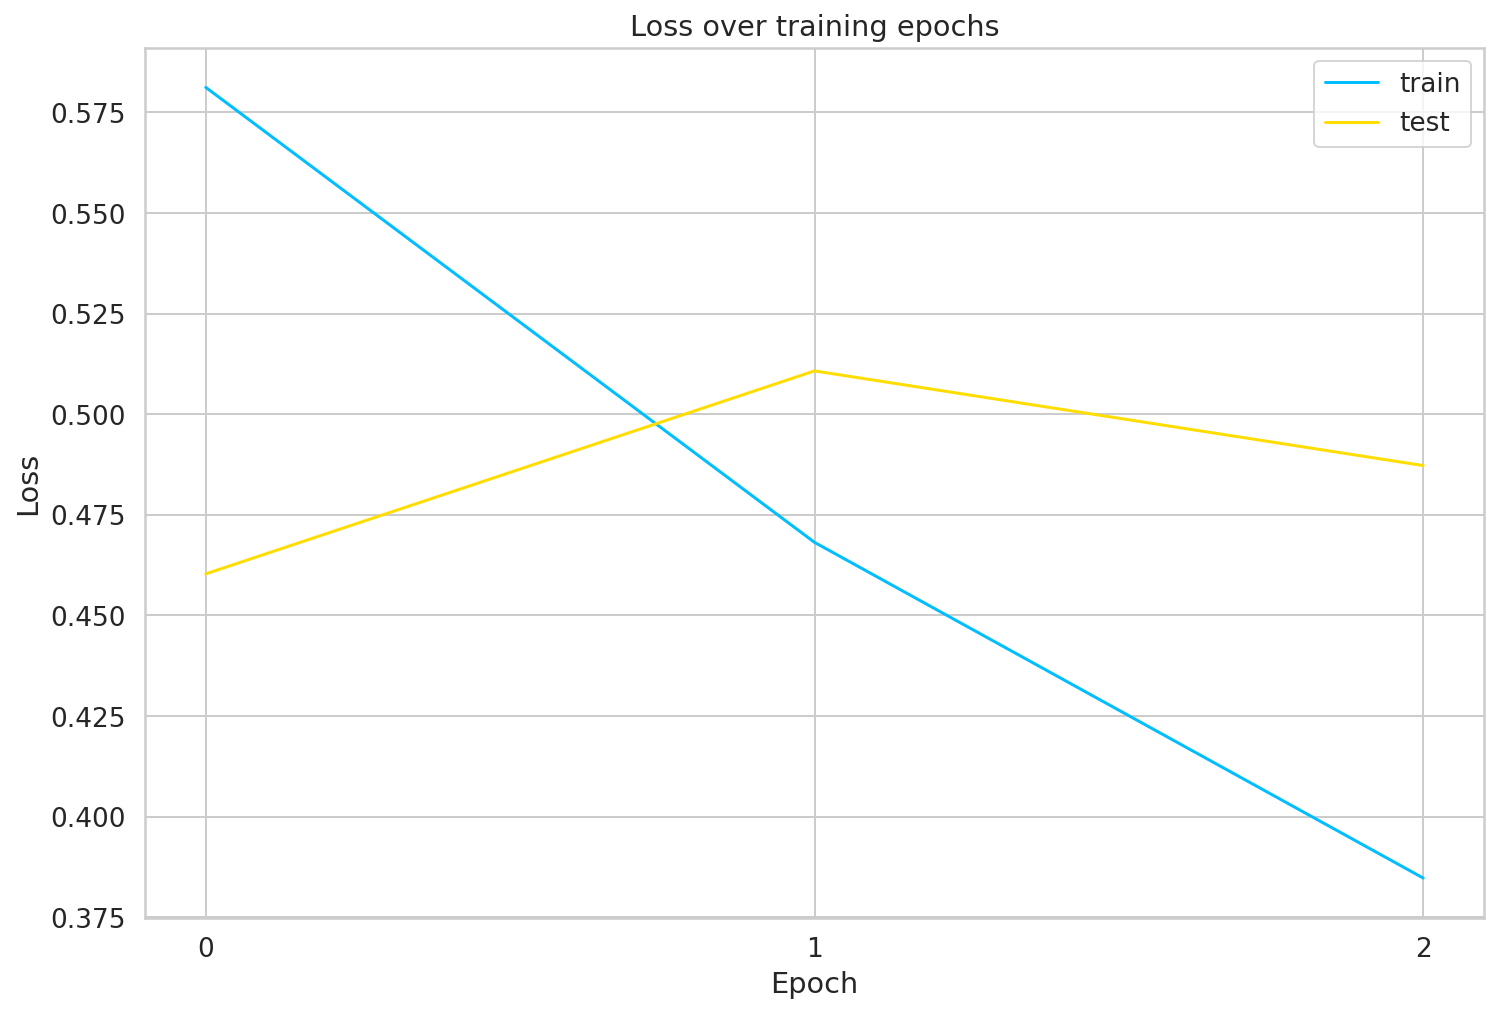

In [87]:
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

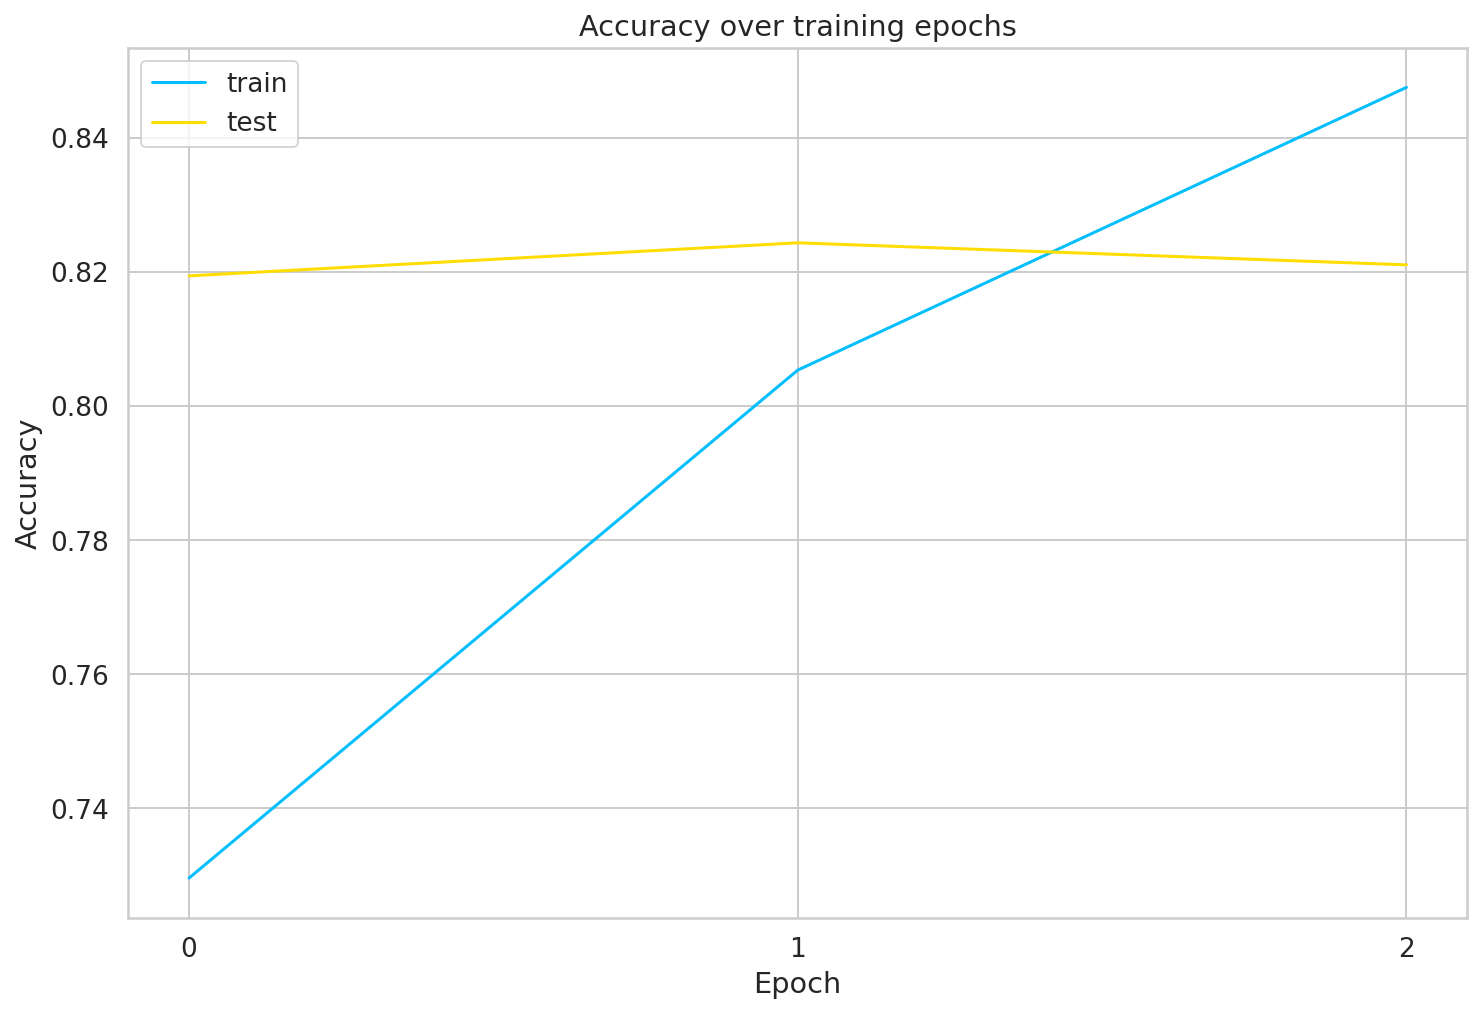

In [88]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

Evaluate the model
Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.


In [89]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

48/48 [==============================] - 4s 89ms/step - loss: 0.4531 - acc: 0.8339
train acc 0.8940886855125427
test acc 0.8338804841041565


In [90]:
data.test_x

array([[  101,  6215,  6499, ...,     0,     0,     0],
       [  101,  3972, 22890, ...,     0,     0,     0],
       [  101,  2610, 11927, ...,     0,     0,     0],
       ...,
       [  101, 10611,  2386, ...,     0,     0,     0],
       [  101,  8505, 19718, ...,     0,     0,     0],
       [  101,  7798, 17603, ...,     0,     0,     0]])

In [91]:
y_pred = model.predict(data.test_x).argmax(axis=-1)
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79       649
           1       0.82      0.91      0.86       874

    accuracy                           0.83      1523
   macro avg       0.84      0.82      0.83      1523
weighted avg       0.84      0.83      0.83      1523



In [92]:
from sklearn.metrics import accuracy_score, precision_score

y_true = data.test_y  # True labels
y_pred = model.predict(data.test_x).argmax(axis=-1)  # Predicted labels

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')

print("Overall Accuracy:", accuracy)
print("Overall Precision:", precision)


Overall Accuracy: 0.8338804990151018
Overall Precision: 0.8383001838542538


In [93]:
from sklearn.metrics import recall_score, f1_score

y_true = data.test_y  # True labels
y_pred = model.predict(data.test_x).argmax(axis=-1)  # Predicted labels

recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Overall Recall:", recall)
print("Overall F1 Score:", f1)


Overall Recall: 0.8211497709907515
Overall F1 Score: 0.8264073131492792


In [94]:
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels in data.test_y and predicted labels in y_pred
cm = confusion_matrix(data.test_y, y_pred)
print(cm)


[[477 172]
 [ 81 793]]


In [95]:
data.test_y.shape


(1523,)

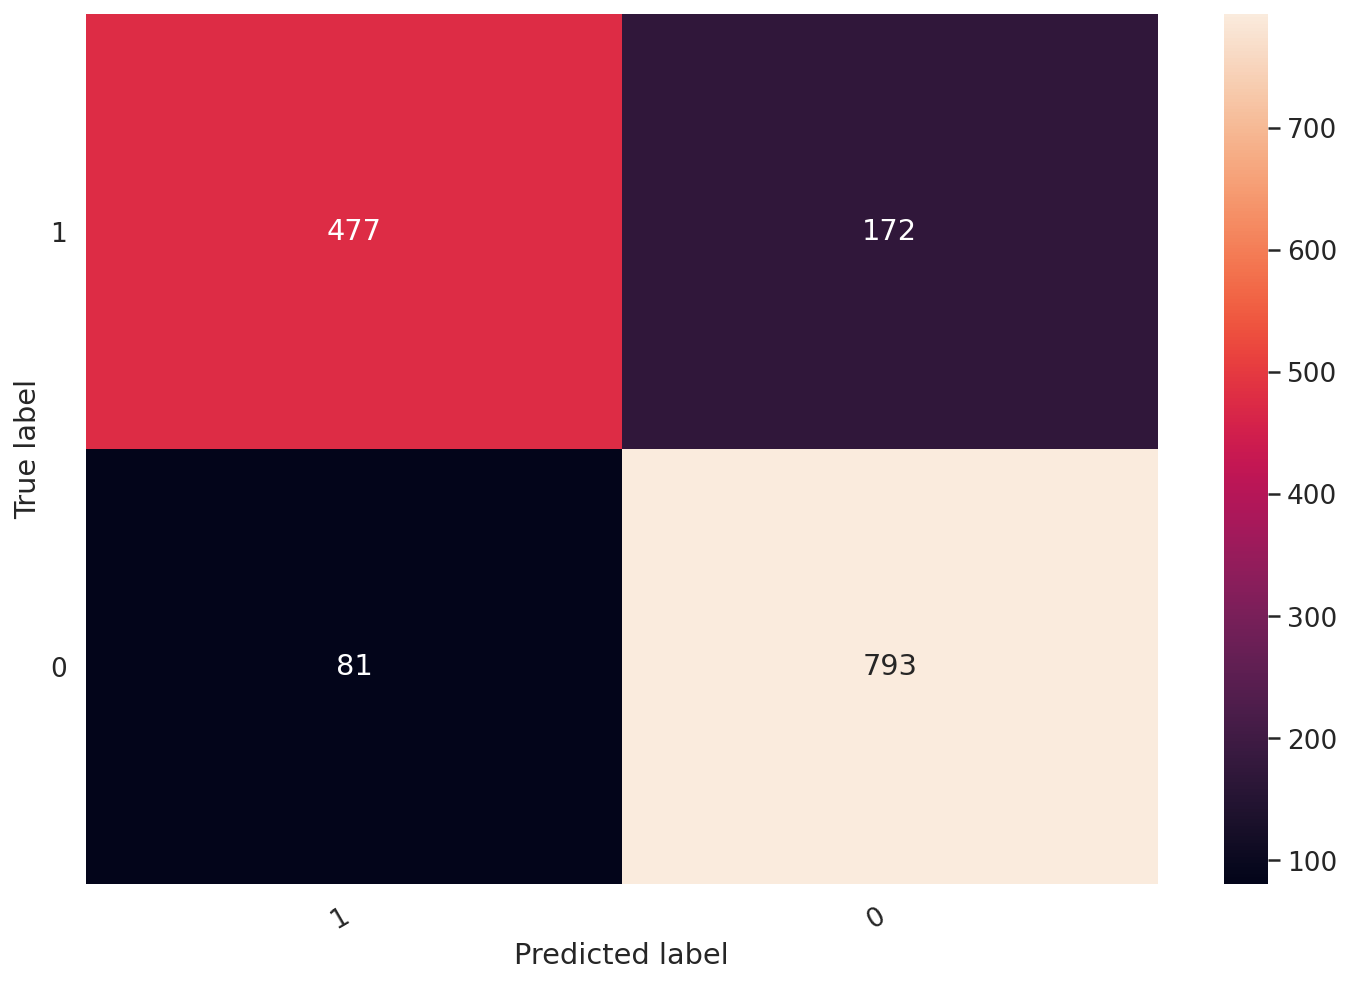

In [96]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [97]:
def testTweet(sentences):
    pred_tokens = map(tokenizer.tokenize, sentences)
    pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
    pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

    pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
    pred_token_ids = np.array(list(pred_token_ids))

    predictions = model.predict(pred_token_ids).argmax(axis=-1)

    for text, label in zip(sentences, predictions):
        if classes[label]==1:
            target="Disaster Tweet"
            print("text:", text, "\nClass:", target)
            print()
        else:
            target="Normal Tweet"
            print("text:", text, "\nClass:", target)
            print()

  

In [98]:
GivenTweets = [
     "Heard about #earthquake is different cities, stay safe everyone.",
    "No I don't like cold!",
    "@RosieGray Now in all sincerety do you think the UN would move to Israel if there was
    a fraction of a chance of being annihilated?"
  ]
testTweet(GivenTweets)

text: Heard about #earthquake is different cities, stay safe everyone. 
Class: Disaster Tweet

text: No I don't like cold! 
Class: Normal Tweet

text: @RosieGray Now in all sincerety do you think the UN would move to Israel if there was a fraction of a chance of being annihilated? 
Class: Normal Tweet



In [100]:
GivenTweets = [

"There's a massive wildfire spreading in the nearby forest and it's getting closer to our neighborhood! #wildfire #emergency #evacuation",

"COVID-19 cases are rising again in our city. Stay safe and follow the guidelines! #COVID19 #pandemic"]
testTweet(GivenTweets)

text: There's a massive wildfire spreading in the nearby forest and it's getting closer to our neighborhood! #wildfire #emergency #evacuation 
Class: Disaster Tweet

text: COVID-19 cases are rising again in our city. Stay safe and follow the guidelines! #COVID19 #pandemic 
Class: Disaster Tweet



In [101]:
NewDataTest=["A potential terrorist attack in the city. #terrorism #emergency",

"A chemical spill in the river  #chemicalspill #environment #safety",

"Finally finished my home gardening project. My plants are thriving! #gardening green bomb #nature",

"Excited about the upcoming music concert. Can't wait to see my favorite band perform live! #music #concert #livemusic killing music"]
testTweet(NewDataTest)

text: A potential terrorist attack in the city. #terrorism #emergency 
Class: Disaster Tweet

text: A chemical spill in the river  #chemicalspill #environment #safety 
Class: Disaster Tweet

text: Finally finished my home gardening project. My plants are thriving! #gardening green bomb #nature 
Class: Normal Tweet

text: Excited about the upcoming music concert. Can't wait to see my favorite band perform live! #music #concert #livemusic killing music 
Class: Normal Tweet



In [163]:
from tensorflow.keras.models import load_model
from bert import BertModelLayer

loaded_model = load_model('/kaggle/working/ALkAmodel//model.h5', custom_objects={'BertModelLayer': BertModelLayer})
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 57)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 57, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               98432     
_________________________________________________________________
dropout_42 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258 

In [77]:
# Print all model weights
# weights = model.get_weights()
# for i, weight in enumerate(weights):
#     print(f'Weight {i}: {weight}')
# #     print(len(weight))
#     print(len(weights[i]))


In [123]:
# weights = model.get_weights()
# weight_index = 2
# specific_weight = model.get_weights()[weight_index]
# print(f'Specific weight {weight_index}: {specific_weight}')

In [78]:
# class DisasterDetectionDataTest:
#   DATA_COLUMN = "cleaned_text"

#   def __init__(self, tokenizer: FullTokenizer, max_seq_len=192):
#     self.tokenizer = tokenizer
#     self.max_seq_len = max_seq_len

#   def generate_embeddings(self, test_data):
#     x = []
#     for _, row in tqdm(test_data.iterrows()):
#       text = row[DisasterDetectionData.DATA_COLUMN]
#       tokens = self.tokenizer.tokenize(text)
#       tokens = ["[CLS]"] + tokens + ["[SEP]"]
#       token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
#       input_ids = token_ids[:min(len(token_ids), self.max_seq_len - 2)]
#       input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
#       x.append(np.array(input_ids))
    
#     return np.array(x)


In [79]:
class DisasterDetectionDataTest:
    DATA_COLUMN = "cleaned_text"

    def __init__(self, tokenizer: FullTokenizer, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def generate_embeddings(self, test_data):
        x = []
        for _, row in tqdm(test_data.iterrows()):
            text = row[DisasterDetectionData.DATA_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            input_ids = token_ids[:min(len(token_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))

        return np.array(x)


In [90]:
# data_test = DisasterDetectionDataTest(tokenizer, max_seq_len=57)
# data_test

In [91]:
# test_embeddings = data_test.generate_embeddings(test_df)
# test_embeddings

In [92]:
# test_embeddings,test_embeddings.shape

In [93]:

# y_pred = model.predict(test_embeddings).argmax(axis=-1)
# y_pred 
# # print(classification_report(test_embeddings, y_pred))
# # predictions = model.predict(test_embeddings)
# # predicted_labels = np.argmax(predictions, axis=-1)

In [94]:
# test_df.shape

In [95]:
# print(test_df[0:10],y_pred[0:10])

In [71]:


# Define a function to predict tweet types
def predict_tweet_types(sentences, tokenizer, model):
    # Tokenize the sentences
    pred_tokens = map(tokenizer.tokenize, sentences)
    pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
    pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

    # Pad the token ids to the maximum sequence length used during training
    pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
    pred_token_ids = np.array(list(pred_token_ids))

    # Predict the tweet types
    predicted_probabilities = model.predict(pred_token_ids)
    predicted_classes = predicted_probabilities.argmax(axis=-1)

    # Print the predicted tweet types
    for text, label in zip(sentences, predicted_classes):
        if classes[label]==1:
            target="Disaster Tweet"
            print("text:", text, "\nClass:", target)
            print()
        else:
            target="Normal Tweet"
            print("text:", text, "\nClass:", target)
            print()


In [72]:

sentences = [
    "Heavy @@@@@Rainfall.",
   "too much rush in temple",
    "Can't believe there was a tornado in our area.",
    "The weather is so amazing today.",
     "too much rush in temple,people died.",
    "We experienced heavy rain today",
    " its Raining  but it may stop after some time"
]



In [73]:
# Recreate the tokenizer object with the same vocab file
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
predict_tweet_types(sentences, tokenizer, model)

NameError: name 'predict_tweet_types' is not defined

In [174]:
print("output")

output
